# Multi-Panel Plots

There are times when it is convenient to plot multiple maps on a single figure. This notebook will illustrate how to go about making a two-panel plot.

We are going to use Siphon to access the most current GFS model output and from that data we will plot 500-hPa heights over the CONUS!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from datetime import datetime, timedelta
from netCDF4 import num2date
import xarray as xr

## Xarray

Another way to read in data is through the module xarray.

In [2]:
data = xr.open_dataset('http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/'+
                  'GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171103_1200.grib2')

print(data)

<xarray.Dataset>
Dimensions:                                                          (altitude_above_msl: 3, height_above_ground: 2, isobaric: 31, isobaric1: 1, isobaric2: 21, isobaric3: 26, isobaric4: 17, isobaric5: 25, lat: 361, lon: 720, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 1)
Coordinates:
  * lat                                                              (lat) float32 90.0 ...
  * lon                                                              (lon) float32 0.0 ...
    reftime                                                          datetime64[ns] ...
  * time                                                             (time) datetime64[ns] 2017-11-03T12:00:00 ...
  * isobaric                                                         (isobaric) float32 100.0 ...
  * sigma                    

In [3]:
# Get the name of the dimensions because grib is stupid
dtime = data.variables['Geopotential_height_isobaric'].dims[0]
dlev = data.variables['Geopotential_height_isobaric'].dims[1]

# Get all of the geopotential height data
hght = data.variables['Geopotential_height_isobaric'].data

# Get the dimension data
lats = data.variables['lat'].data
lons = data.variables['lon'].data
levs = data.variables[dlev].data
time = data.variables[dtime]
# Get the valid times from the file
vtimes = []
for t in range(data.time.size):
    vtimes.append(datetime.utcfromtimestamp(data.time[t].data.astype('O')/1e9))

# Set up our array of latitude and longitude values
clons, clats = np.meshgrid(lons, lats)

# Find the appropriate index values for the desired pressure levels
ilev500 = np.where(levs/100 == 500.)[0][0]
ilev850 = np.where(levs/100 == 850.)[0][0]

# Subset the heights to get them for 850 and 500 hPa
hght_500 = hght[0,ilev500,:,:]
hght_850 = hght[0,ilev850,:,:]

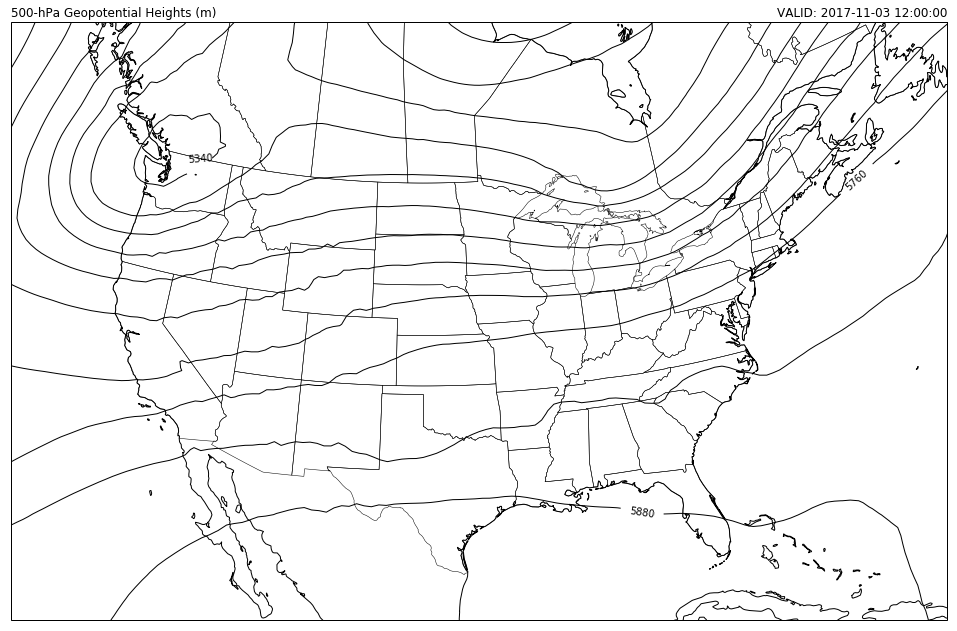

In [4]:
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0

# Set up our projection
mapcrs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = plt.subplot(111,projection=mapcrs)

# Set graphic display extent
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-68,20,55],ccrs.Geodetic())

# Add geographical reference lines to plot
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Plot contours of desired data
clev500 = np.arange(4500,6000,60)
cs = ax.contour(clons,clats,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot some titles and show figure
plt.title('500-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()

Pretty nice plot, but what if I wanted to focus on a smaller region? You can set an extent of your map window with a simple matplotlib function. This works well if you are looking to focus on a smaller area and not plotting too much outside of that area.

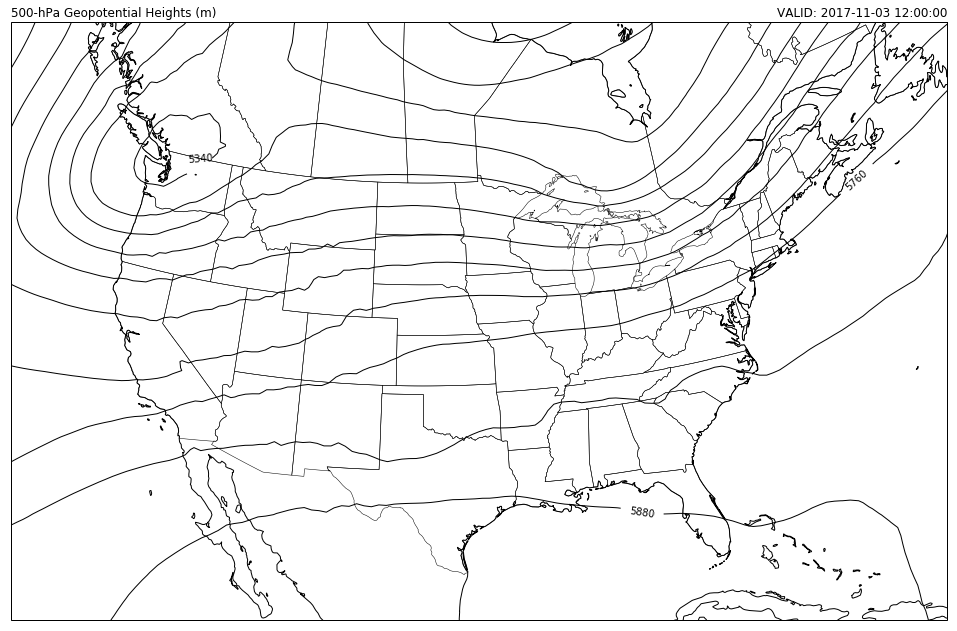

In [5]:
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0

# Set up our projection
mapcrs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = plt.subplot(111,projection=mapcrs)

# Set graphic display extent
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-68,20,55],ccrs.Geodetic())

# Add geographical reference lines to plot
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Plot contours of desired data
clev500 = np.arange(4500,6000,60)
cs = ax.contour(clons,clats,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot some titles and show figure
plt.title('500-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()

Nice map, but the 500-hPa raw heights are a bit wavey. Can we smooth them out a little?

Sure thing! Just need to use the **scipy** module function **ndimage**.

In [6]:
# The following line will perform a gaussian weighted filter, 
#  see documentation for details.
# The smoothing is altered by the sigma parameter, 
#  I've found 1.5 to be a good value
Z_500 = ndimage.gaussian_filter(hght_500, sigma=1.5, order=0)
Z_850 = ndimage.gaussian_filter(hght_850, sigma=1.5, order=0)

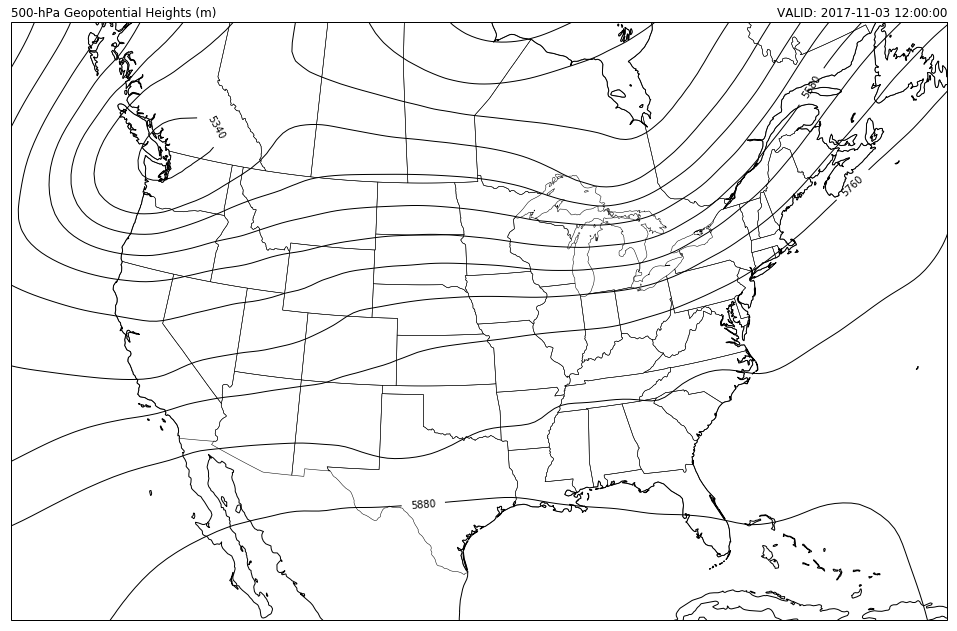

In [7]:
# Set up our projection
mapcrs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = plt.subplot(111,projection=mapcrs)

# Set graphic display extent
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-68,20,55],ccrs.Geodetic())

# Add geographical reference lines to plot
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Plot contours of desired data
clev500 = np.arange(4500,6000,60)
cs = ax.contour(clons,clats,Z_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot some titles and show figure
plt.title('500-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()

## Multi-panel Plots

Information from the matplotlib website

http://matplotlib.org/api/pyplot_api.html?highlight=subplot#matplotlib.pyplot.subplot

Below we'll make a two-panel plot in 2 rows, 1 column

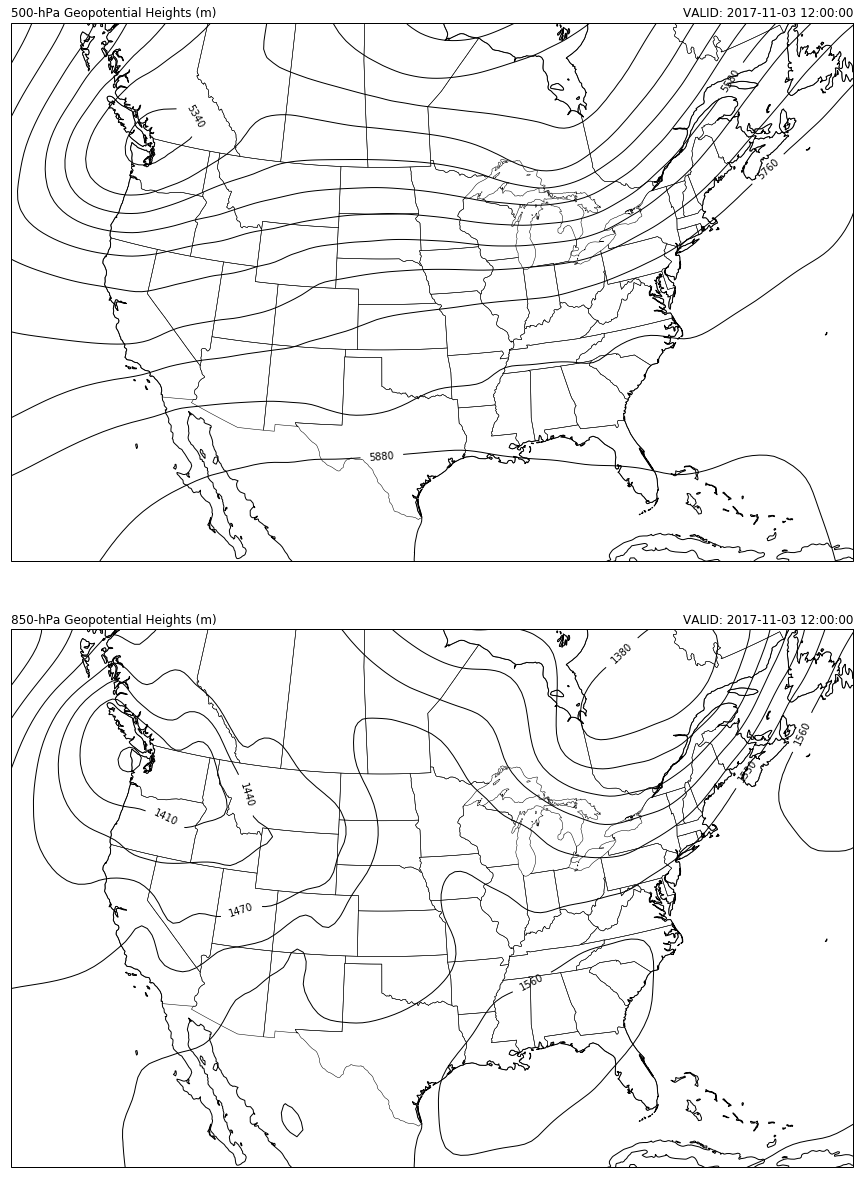

In [8]:
# Set up our projection
mapcrs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Set up and plot figure (oriented portrait style)
fig=plt.figure(1,figsize=(12.,17.))

# First Plot
# Set up the axes to plot on for top map
# plt.subplot([nrow][ncol][fig number], **kwargs)
ax = plt.subplot(211,projection=mapcrs)

# Set graphic display extent for this axes
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-125,-68,20,55],ccrs.Geodetic())

# Add geographical reference lines to plot for this part of figure 
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Plot contours on this axes
clev500 = np.arange(4500,6000,60)
cs = ax.contour(clons,clats,Z_500[:,:],clev500,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=5, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot titles for this axes
plt.title('500-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')


# Second Plot, new axes!
# Set up the axes to plot on for bottom map
ax2 = plt.subplot(212,projection=mapcrs)

# Set graphic display extent for new axes
#   ax.set_extent([west long, east long, south lat, north lat])
ax2.set_extent([-125,-68,20,55],ccrs.Geodetic())

# Add geographical reference lines to plot for new axes
ax2.coastlines('50m',edgecolor='black',linewidth=0.75)
ax2.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Plot contours on new axes
clev850 = np.arange(1500-30*5,1500+30*5,30)
cs2 = ax2.contour(clons,clats,Z_850[:,:],clev850,colors='k',
                linewidths=1.0,linestyles='solid',
                transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=5, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot title for new axes
plt.title('850-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')

# Overall Figure Title (Superior Title)
#fig.suptitle('Two Panel Plot Example',size=28)

plt.tight_layout()
plt.show()